# Mapping Bing Maps tiles used in the Facebook Movement Maps to NUTS3

We map the Bing Maps tiles given by quadkeys to NUTS3 regions

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
from geopandas.tools import sjoin
import shapely
from shapely.geometry import Point
import mercantile
import pickle
import networkx as nx
from shapely.geometry import shape
from geopandas.tools import overlay

In [2]:
import sys
from pathlib import Path
path = str(Path.cwd().parents[0])

root_map = path+'/data/geo_shapefiles/NUTS_Level_3__January_2018__Boundaries-shp/NUTS_Level_3__January_2018__Boundaries.shp'
root_networks = path+"/data/processed/networks/"
root_processed = path+"/data/processed/"

In [3]:
# load baseline node quadkeys
lscc_nodes = []
with open(root_networks+'node_quadkeys.txt', 'r') as filehandle:
    for line in filehandle:
        curr_quadkey = line[:-1]
        lscc_nodes.append(curr_quadkey)

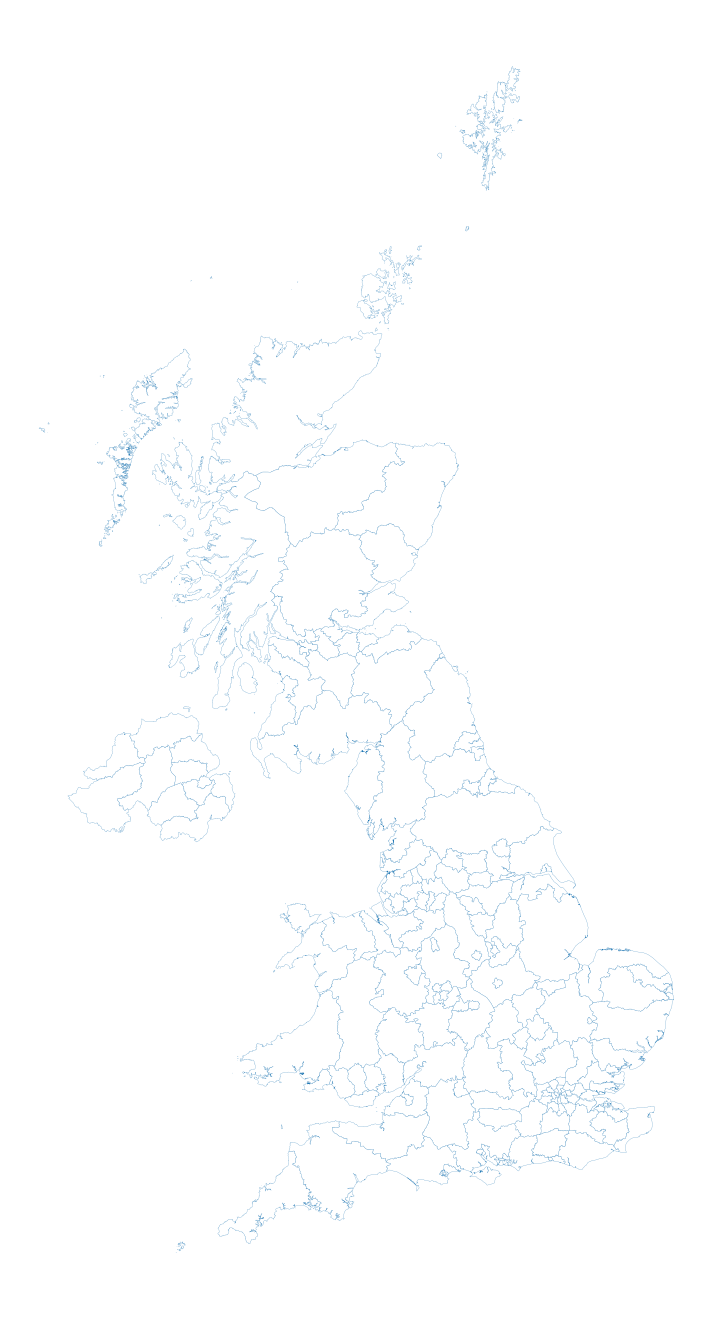

In [4]:
df1 = gpd.read_file(root_map)
df1 = df1.to_crs("EPSG:3395")

df1['DUMMY'] = 1
df2 = df1.dissolve(by = 'DUMMY')

f, ax = plt.subplots(1, figsize=(40, 24))
df1.plot(ax = ax,  alpha = 1, linewidth = 0.2, edgecolor='tab:blue', color = 'white')
ax.set_axis_off()
plt.show()

Read in the quadkey file, geocode all the quadkeys and plot their intersection with the geographic map file 

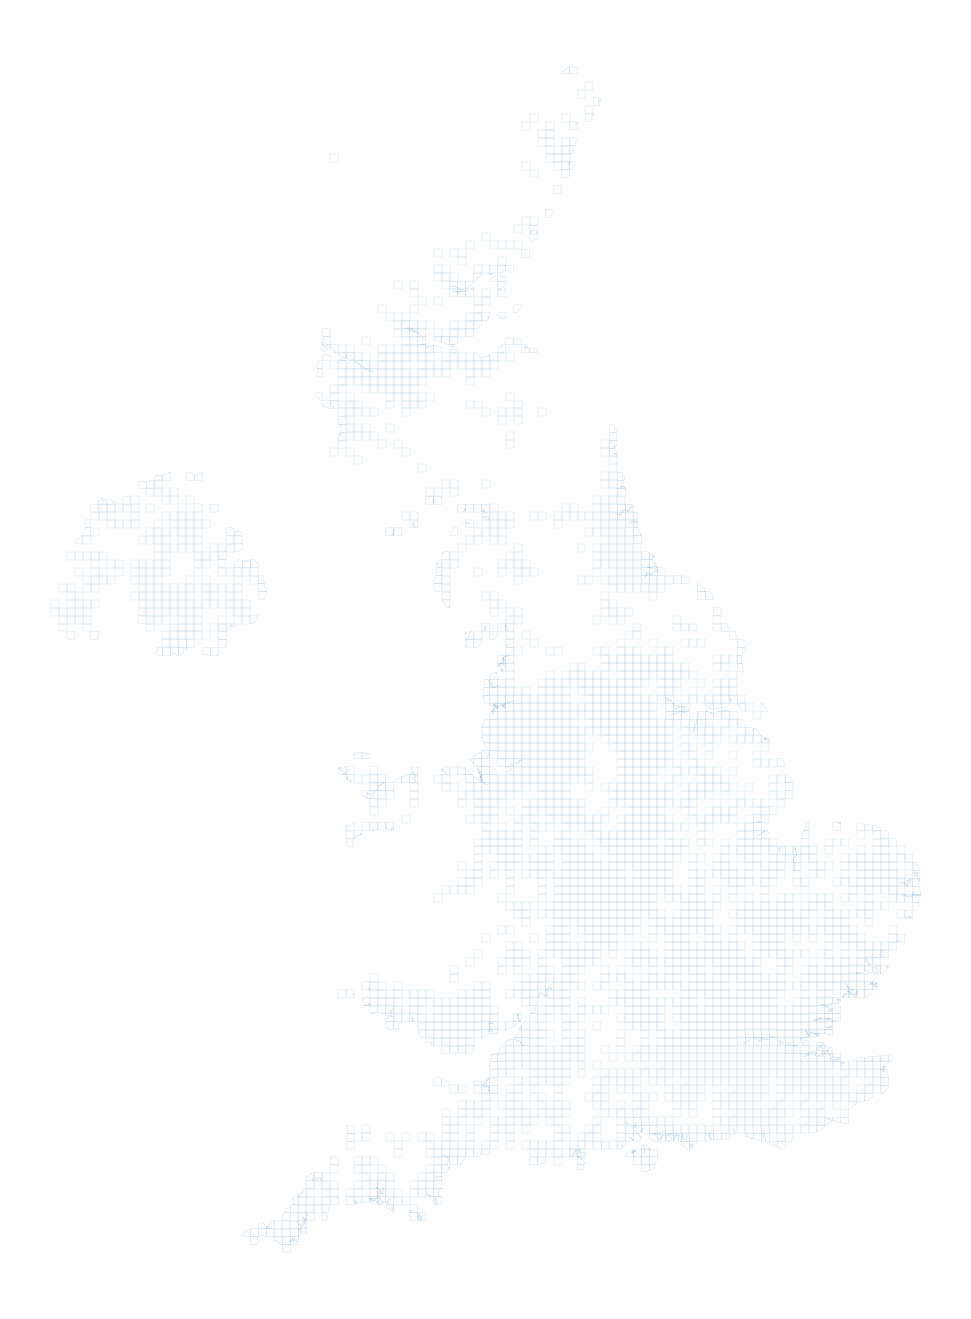

In [5]:
quadkeys = lscc_nodes
polys = []

for quadkey in quadkeys:
    tile = mercantile.feature(mercantile.quadkey_to_tile(quadkey), projected = 'web mercator')
    polys.append(tile.get('geometry'))
geom = [shape(i) for i in polys]
gdf = gpd.GeoDataFrame({'geometry':geom, 'quadkey':quadkeys}, crs = "EPSG:4326")
gdf = gdf.to_crs("EPSG:3395")

newdf = overlay(gdf, df2, how="intersection")
f, ax = plt.subplots(1, figsize=(40, 24))
newdf.plot(ax = ax,  alpha = 1, linewidth = 0.1, edgecolor='tab:blue', facecolor = 'none')
ax.set_axis_off()
plt.show()

For each region within the geographic map file, identify the tiles intersecting with the region, and their area. As the areas are exhaustive with repsect to the country or region of interest, the total tile area covered can be taken as the total 'landed' area of the tile.

There is a little limitation here. For land borders, we do not know how much of a tile's activity is from either side of the border. This way we take it as all falling within the area of interest. It's an edge case and probably unimportant

For sense checking we get a map of each region with the tiles overlapping it. 

In [6]:
geo_col = "nuts318cd"

regs = list(set(df1[geo_col]))

rec = pd.DataFrame(gdf['quadkey'])

for reg in regs:
    df2 = df1.loc[df1[geo_col] == reg]
    
    newdf = overlay(gdf, df2, how="intersection")
    newdf[reg] = newdf['geometry'].area

    # print(reg)
    # f, ax = plt.subplots(1, figsize=(30, 18))
    # ax = df2.plot(linewidth=1, ax=ax, facecolor = 'none', edgecolor = 'k')
    # ax = newdf.plot(color = 'tab:red', alpha = 0.5, linewidth=2, ax=ax, edgecolor = 'k')
    # ax.set_axis_off()
    # plt.show()
    
    newdf = newdf.filter(items = ['quadkey',reg])
    rec = pd.merge(rec,newdf,how='outer', on='quadkey')

    

Now we add a leading '_' to avoid problems with reading in saved files with numerical column headers (i.e. quadkeys) 

The first block takes the areas of each tile within the region of interest and calculates the total. This is the tile total area. Rows are divided by this total to give the proportion of each tile's area falling within each region. 

In [7]:
rec = rec.fillna(0)

#Insert a leading '_' to stop numerical transformation
rec['quadkey'] = '_'+rec['quadkey']

rec.index = rec['quadkey']
del rec['quadkey']

# takes the areas of each tile within the region of interest and 
# calculates the total
rec['TOTAL'] = rec.sum(axis = 1)
rec2 = rec.loc[rec['TOTAL'] > 0]
# rows are divided by this total to give the proportion of each tile's 
# area falling within each region
rec2 = rec2.divide(rec2['TOTAL'], axis = 0)
del rec['TOTAL']
del rec2['TOTAL']
rec2.to_csv(root_processed+"MOVEMENT_QUADKEY_NUTS3_GB.csv")